In [1]:
import pandas as pd
import numpy as np
import os
import glob
import datetime

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)
# import tensorflow

# from tensorflow.compat.v1.keras.backend import get_session
# tensorflow.compat.v1.disable_v2_behavior()
# import shap

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout
from sklearn import preprocessing

import tensorflow as tf

import numpy as np
import os
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
from os.path import isfile, join
from sys import getsizeof
import glob

from random import *

import matplotlib.pyplot as plt
#plt.ion()
%matplotlib widget

#import mpld3
#mpld3.enable_notebook()
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Only using years 2010, 2011, 2012, 2013, and 2014 because of the auroral boundary database used only has those dates

In [2]:
file_load_df_cumulative = '/home/jackalak/heartbeat_work/HEARTBEAT/ParticlePrecipitation/ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine.csv'
DMSP_DATA_DIR=''
df_cumulative = pd.read_csv(os.path.join(DMSP_DATA_DIR,file_load_df_cumulative))
df_cumulative = df_cumulative.sort_values(by=['ID_SC', 'Datetimes'])
df_cumulative = df_cumulative.set_index('Datetimes')
df_cumulative.index = pd.to_datetime(df_cumulative.index)

cols_to_drop_validation = [c for c in df_cumulative.columns if ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
# cols_to_drop_validation = [c for c in df.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('5min' in c) | ('15min' in c) | ('newell' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]

df_cumulative = df_cumulative.drop(columns=cols_to_drop_validation)

# Separate training and testing data
mask_val = [(df_cumulative.index.year == 2010) & (df_cumulative['ID_SC'].values==16)]
df_val = df_cumulative[mask_val[0]].copy(deep=True)
df_train = df_cumulative.copy(deep=True).drop( df_cumulative.index[mask_val[0]])

mask_for_2010_to_2014 = [(df_train.index.year == 2010) | (df_train.index.year == 2011)
                         | (df_train.index.year == 2012) |(df_train.index.year == 2013)
                         | (df_train.index.year == 2014)]
df_train = df_train[mask_for_2010_to_2014[0]]
df_train = df_train.sort_values(by=['ID_SC', 'Datetimes'])
df_val = df_val.sort_values(by=['ID_SC', 'Datetimes'])

In [3]:
# Construct X and y
feature_cols = [c for c in df_train.columns if not 'ELE' in c]
#print( (feature_cols))
#print(df_cumulative.columns)
X_val = df_val[feature_cols].copy(deep=True)
y_val = df_val['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
y_train = df_train['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))
X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)

# Read in the the auroral regions from a pickle file (constructed from auroral boundary transition points) 

In [4]:

df_val = pd.read_pickle("/home/jackalak/heartbeat_work/HEARTBEAT/AuroralBoundaries/with_aurora_type_val.pkl")
df_train = pd.read_pickle("/home/jackalak/heartbeat_work/HEARTBEAT/AuroralBoundaries/with_aurora_type_train.pkl")


# The boundary transition type regions can be reduced to 3 instead of 4 regions (plus unknown region 5), because going into the auroal region from the equatorial region or the polar region is the same for our intention of labeling just equatorial region, auroral, region, or polar region. 

# therefore type 4 is the same as type 1

In [5]:
df_val['aurora_type'][ df_val['aurora_type']==4 ]= 1
df_train['aurora_type'][ df_train['aurora_type']==4 ]= 1



In [6]:

mask = ( np.isnan(df_train['aurora_type'])==False )
df_train_clean = df_train[mask].copy(deep=True)
mask = ( np.isnan(df_val['aurora_type'])==False)
df_val_clean = df_val[mask].copy(deep=True)

In [7]:

# Construct X and y
feature_cols = [c for c in df_train_clean.columns if not 'ELE' in c]
#print( (feature_cols))
#print(df_cumulative.columns)
X_val = df_val_clean[feature_cols].copy(deep=True)
y_val = df_val_clean['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train_clean[feature_cols].copy(deep=True)
y_train = df_train_clean['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))

X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)

Y = np.array(y_train_log, dtype=np.float32)


In [8]:
X_train_no_aurora_type = X_train.drop(columns='aurora_type')
X_val_no_aurora_type = X_val.drop(columns='aurora_type')
scaler_X = scaler_X.fit(X_train_no_aurora_type.values)
X_val_no_aurora_type_scaled = scaler_X.transform(X_val_no_aurora_type.values)
X_train_no_aurora_type_scaled = scaler_X.transform(X_train_no_aurora_type.values)

y_train_aurora_type = X_train['aurora_type']
y_val_aurora_type = X_val['aurora_type']

In [9]:

label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

integer_encoded = label_encoder.fit_transform(y_train_aurora_type)
print(integer_encoded.shape)

integer_encoded_train = integer_encoded.reshape(len(integer_encoded), 1)
print(integer_encoded.shape)

y_train_aurora_type_encoded = onehot_encoder.fit_transform(integer_encoded_train)
integer_encoded = label_encoder.fit_transform(y_val_aurora_type)
integer_encoded_val = integer_encoded.reshape(len(integer_encoded), 1)
y_val_aurora_type_encoded = onehot_encoder.fit_transform(integer_encoded_val)


(720998,)
(720998,)


False
(23848, 148)
(324651,)
(324651,)
(324651, 148)
(324651,)
(324651, 3)
equatorial 0.22883672092633456
auroral 0.10463513594006918
polar 0.11624617848203142


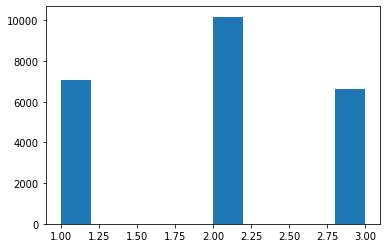

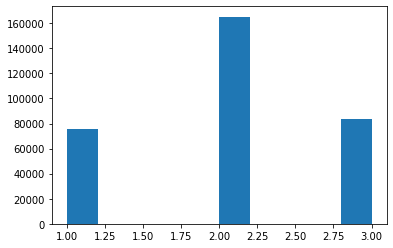

In [10]:

mask = [ (np.isnan(df_train['aurora_type'])==False) & (df_train['aurora_type'] != 5 ) ]
df_train_clean = df_train[mask[0]].copy(deep=True)
print((mask[0].any())==False)
mask = [ (np.isnan(df_val['aurora_type'])==False) & (df_val['aurora_type'] != 5 ) ]
df_val_clean = df_val[mask[0]].copy(deep=True)



# Construct X and y
feature_cols = [c for c in df_train_clean.columns if not 'ELE' in c]
from sklearn import preprocessing
X_val = df_val_clean[feature_cols].copy(deep=True)
y_val = df_val_clean['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train_clean[feature_cols].copy(deep=True)
y_train = df_train_clean['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))


X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)

Y = np.array(y_train_log, dtype=np.float32)

X_train_no_aurora_type = X_train.drop(columns='aurora_type')
X_val_no_aurora_type = X_val.drop(columns='aurora_type')
scaler_X = scaler_X.fit(X_train_no_aurora_type.values)
X_val_no_aurora_type_scaled = scaler_X.transform(X_val_no_aurora_type.values)
print(X_val_no_aurora_type_scaled.shape)
X_train_no_aurora_type_scaled = scaler_X.transform(X_train_no_aurora_type.values)

y_train_aurora_type = X_train['aurora_type']
y_val_aurora_type = X_val['aurora_type']

label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

integer_encoded = label_encoder.fit_transform(y_train_aurora_type)
print(integer_encoded.shape)

integer_encoded_train = integer_encoded.reshape(len(integer_encoded), 1)
print(integer_encoded.shape)

y_train_aurora_type_encoded = onehot_encoder.fit_transform(integer_encoded_train)
integer_encoded = label_encoder.fit_transform(y_val_aurora_type)
integer_encoded_val = integer_encoded.reshape(len(integer_encoded), 1)
y_val_aurora_type_encoded = onehot_encoder.fit_transform(integer_encoded_val)

print(X_train_no_aurora_type_scaled.shape)

print(y_train_aurora_type.shape)
print(y_train_aurora_type_encoded.shape)

sum(df_val_clean['aurora_type']==2)/df_val_clean.shape[0]
sum(df_train_clean['aurora_type']==2)/df_train_clean.shape[0]

print('equatorial', sum(df_train['aurora_type']==2)/df_train['aurora_type'].shape[0])
print('auroral', sum(df_train['aurora_type']==1)/df_train['aurora_type'].shape[0])
print('polar', sum(df_train['aurora_type']==3)/df_train['aurora_type'].shape[0])

plt.hist(y_val_aurora_type)
plt.show()
plt.hist(y_train_aurora_type)
plt.show()

746/746 [==============================] - 1s 1ms/step - loss: 0.1872 - accuracy: 0.9190


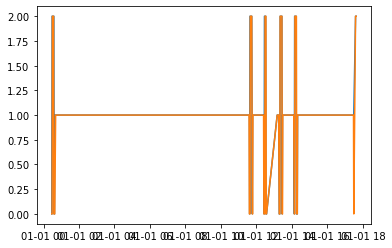

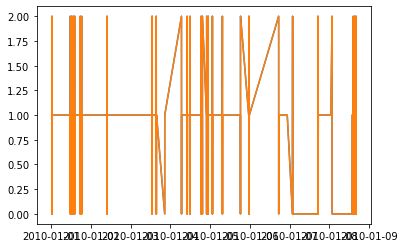

In [14]:
import tensorflow

model = Sequential()
model.add(Dense(int(256), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3,activation='softmax'))
#compile model using accuracy to measure model performance
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer='adam',  metrics=['accuracy'])
history = model.fit(X_train_no_aurora_type_scaled, y_train_aurora_type_encoded, validation_data=(X_val_no_aurora_type_scaled, y_val_aurora_type_encoded), batch_size=32,epochs=1)

# filename = 'best_auroral_region_predictor'

# model = tensorflow.keras.models.load_model(filename)
# # model.save(filename)
# model.save_weights('best_auroral_region_predictor_sampleweights_weights.h5')
model.load_weights('best_auroral_region_predictor_sampleweights_weights.h5')
model.evaluate(X_val_no_aurora_type_scaled, y_val_aurora_type_encoded)

results = (model.predict_classes(X_val_no_aurora_type_scaled))#, y_val_log.values)#, batch_size=128)

df_results = pd.DataFrame(data=results, index = X_val.index)
val = pd.DataFrame(data=integer_encoded_val, index = X_val.index)
# plt.figure()

# plt.plot( integer_encoded_val[:3000])
# plt.plot(results[:3000])
# plt.show()
plt.figure()

plt.plot( val[:100])
plt.plot(df_results[:100])
plt.show()

plt.figure()

plt.plot( val[:500])
plt.plot(df_results[:500])
plt.show()

# Now use this Auroal region predictor model to predict what type the "unknown/unspecified" regions are.  Then combine this predicted data with the known training and test data

In [15]:
 
mask = [ (np.isnan(df_train['aurora_type'])==True) | (df_train['aurora_type'] == 5 ) ]
df_train_pred = df_train[mask[0]].copy(deep=True)
print((mask[0].any())==False)
mask = [ (np.isnan(df_val['aurora_type'])==True) | (df_val['aurora_type'] == 5 ) ]
df_val_pred = df_val[mask[0]].copy(deep=True)
print(df_train_pred.shape)
print(df_val_pred.shape)

False
(397248, 150)
(31362, 150)


In [16]:
# Construct X and y
feature_cols = [c for c in df_train_pred.columns if (not ( 'ELE' in c) | ('aurora_type' in c))]
X_train = df_train_pred[feature_cols].copy(deep=True)
X_val = df_val_pred[feature_cols].copy(deep=True)
print(X_train.shape)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)
X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)
#scaler_X = scaler_X.fit(X_train_no_aurora_type.values)



(397248, 148)


In [17]:

print(X.shape)

print((model.predict_classes(X_train_no_aurora_type_scaled)).shape)
print(df_train_pred.shape)

df_train_pred['aurora_type']= model.predict_classes(X)+1
df_val_pred['aurora_type']= model.predict_classes(X_test)+1

# plt.figure()
# plt.hist(df_train_pred['aurora_type'])
# plt.figure()
# plt.hist(df_train_clean['aurora_type'])

print(df_train_pred.shape)
print(df_train_clean.shape)

frames = [df_train_clean, df_train_pred]
df_train_new = pd.concat(frames)
frames = [df_val_clean, df_val_pred]
df_val_new = pd.concat(frames) 

print(df_val_new.values.shape)

(397248, 148)
(324651,)
(397248, 150)
(397248, 150)
(324651, 150)
(55210, 150)


In [18]:

# Construct X and y
feature_cols = [c for c in df_train_new.columns if not 'ELE' in c]

X_val = df_val_new[feature_cols].copy(deep=True)
y_val = df_val_new['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train_new[feature_cols].copy(deep=True)
y_train = df_train_new['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))

X = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_val_scaled, dtype=np.float32)


In [29]:
sample_weights = np.ones((X_train.values.shape[0]))
for i in range(0,X_train.values.shape[0]):
    if X_train['aurora_type'].values[i]==1:
        sample_weights[i]=10

# plt.figure()
# plt.hist(sample_weights)
# plt.figure()
# plt.hist(X_train['aurora_type'].values)

# Now with the supervised auroral type values and the predicted (unsupervised) type values as a new column in the input X, predict the scalar energy flux y

In [19]:
model = Sequential()

model.add(Dense(int(256), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))


#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam',  metrics=['mse','mae'])

history = model.fit(X, np.array(y_train_log), 
    validation_data=(X_test, np.array(y_val_log)), batch_size=1024,epochs=1, sample_weight=sample_weights)

In [21]:
filename = 'best_with_auroral_region_weights'

# model.save(filename)

# model = tensorflow.keras.models.load_model(filename)
# model.save_weights('best_with_auroral_region_weights_weightfile.h5')
model.load_weights('best_with_auroral_region_weights_weightfile.h5')

# print(history.history.keys())
# plt.figure()
# # summarize history for loss
# plt.plot(history.history['loss'][20:])
# plt.plot(history.history['val_loss'][20:])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# plt.figure()
# # summarize history for loss
# plt.plot(history.history['loss'][20:])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# plt.figure()
# # summarize history for loss
# plt.plot(history.history['val_loss'][20:])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# plt.figure()
# # summarize history for loss
# plt.plot(history.history['val_loss'][200:])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [22]:
model.evaluate(X_val_scaled,y_val_log)


1726/1726 [==============================] - 2s 972us/step - loss: 0.5924 - mean_squared_error: 0.5924 - mean_absolute_error: 0.5501


[0.592354953289032, 0.592354953289032, 0.5500954389572144]

In [23]:
results = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)

df_results = pd.DataFrame(data=results, index = X_val.index)

# plt.figure()
# plt.plot(y_val_log[:500])
# plt.plot(df_results[:500])
# plt.legend(['val', 'result'], loc='upper left')
# plt.show()

# plt.figure()
# plt.plot(y_val_log[:5000])
# plt.plot(df_results[:5000])
# plt.legend(['val', 'result'], loc='upper left')
# plt.show()

# plt.figure()
# plt.plot(y_val_log[:])
# plt.plot(df_results[:])
# plt.legend(['val', 'result'], loc='upper left')
# plt.show()

# plt.figure()
# plt.plot(y_val_log[-500:])
# plt.plot(df_results[-500:])
# plt.legend(['val', 'result'], loc='upper left')
# plt.show()

# plt.figure()
# plt.plot(y_val_log[:])
# plt.plot(df_results[:])
# plt.legend(['val', 'result'], loc='upper left')
# plt.show()

# plt.figure()
# plt.plot(y_val_log[-500:])
# plt.plot(df_results[-500:])
# plt.legend(['val', 'result'], loc='upper left')
# plt.show()

In [35]:
model = Sequential()
model.add(Dense(int(256), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam',  metrics=['mse','mae'])
history = model.fit(X, np.array(y_train_log), 
    validation_data=(X_test, np.array(y_val_log)), batch_size=1024,epochs=1, sample_weight=sample_weights)
model.load_weights('best_with_auroral_region_weights_weightfile.h5')

results = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)
df_results = pd.DataFrame(data=results, index = X_val.index)

indices = np.array(np.linspace(35,80,num=80-35+1,dtype=np.int))

%matplotlib widget


fig, ax1 = plt.subplots(figsize=(10,8))
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('flux', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1.plot(y_val_log[:10000])
ax1.plot(df_results[:10000])

model = Sequential()
model.add(Dense(int(256), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam',  metrics=['mse','mae'])
history = model.fit(X[:,:148], np.array(y_train_log), 
    validation_data=(X_test[:,:148], np.array(y_val_log)), batch_size=1024,epochs=1, sample_weight=sample_weights)
model.load_weights('best_base_line_Weightfile.h5')


results = model.predict(X_val_scaled[:,:148])#, y_val_log.values)#, batch_size=128)
df_results = pd.DataFrame(data=results, index = X_val.index)

ax1.plot(df_results[:10000])

ax1.legend(['true energy flux', 'predicted with auroral region', 'predicted  baseline'], loc='upper left')
plt.title('Weighted samples')
plt.show()


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:purple'
ax2.set_ylabel('MLat', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(y_val_log.index[:10000], X_val['SC_AACGM_LAT'].values[:10000], color=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped


705/705 [==============================] - 1s 2ms/step - loss: 35.7696 - mse: 9.5046 - mae: 1.9002 - val_loss: 2.0697 - val_mse: 2.0697 - val_mae: 1.1414


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

705/705 [==============================] - 1s 2ms/step - loss: 36.7008 - mse: 10.1068 - mae: 1.8710 - val_loss: 2.0783 - val_mse: 2.0783 - val_mae: 1.1482


In [36]:
%matplotlib widget

model = Sequential()
model.add(Dense(int(256), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam',  metrics=['mse','mae'])
history = model.fit(X, np.array(y_train_log), 
    validation_data=(X_test, np.array(y_val_log)), batch_size=1024,epochs=1, sample_weight=sample_weights)
model.load_weights('best_with_auroral_region_weights_weightfile.h5')

results = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)
df_results = pd.DataFrame(data=results, index = X_val.index)

indices = np.array(np.linspace(35,80,num=80-35+1,dtype=np.int))

fig, ax1 = plt.subplots(figsize=(10,8))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('flux', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1.plot(10**y_val_log[:]*1.6e-12)
ax1.plot(10**df_results[:]*1.6e-12)

model = Sequential()
model.add(Dense(int(256), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam',  metrics=['mse','mae'])
history = model.fit(X[:,:148], np.array(y_train_log), 
    validation_data=(X_test[:,:148], np.array(y_val_log)), batch_size=1024,epochs=1, sample_weight=sample_weights)
model.load_weights('best_base_line_Weightfile.h5')

results = model.predict(X_val_scaled[:,:148])#, y_val_log.values)#, batch_size=128)
df_results = pd.DataFrame(data=results, index = X_val.index)

ax1.plot(10**df_results[:]*1.6e-12)

ax1.legend(['true energy flux', 'predicted with auroral region', 'predicted  baseline'], loc='upper left')
plt.title('Weighted samples')
plt.show()


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:purple'
ax2.set_ylabel('MLat', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
#ax2.plot(X_val['SC_AACGM_LAT'][:5000], color=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped


705/705 [==============================] - 1s 2ms/step - loss: 39.6808 - mse: 9.7314 - mae: 2.0122 - val_loss: 2.0506 - val_mse: 2.0506 - val_mae: 1.1237


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

705/705 [==============================] - 1s 2ms/step - loss: 41.7855 - mse: 10.2791 - mae: 1.9152 - val_loss: 2.1507 - val_mse: 2.1507 - val_mae: 1.1709


In [37]:
index = 8000
print(X_val.index[index])

%matplotlib widget

model = Sequential()
model.add(Dense(int(256), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam',  metrics=['mse','mae'])
history = model.fit(X, np.array(y_train_log), 
    validation_data=(X_test, np.array(y_val_log)), batch_size=1024,epochs=1, sample_weight=sample_weights)
model.load_weights('best_with_auroral_region_weights_weightfile.h5')

results = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)
df_results = pd.DataFrame(data=results, index = X_val.index)

indices = np.array(np.linspace(35,80,num=80-35+1,dtype=np.int))

fig, ax1 = plt.subplots(figsize=(10,8))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('flux', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1.plot(10**y_val_log[:]*1.6e-12)
ax1.plot(10**df_results[:]*1.6e-12)


model = Sequential()
model.add(Dense(int(256), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam',  metrics=['mse','mae'])
history = model.fit(X[:,:148], np.array(y_train_log), 
    validation_data=(X_test[:,:148], np.array(y_val_log)), batch_size=1024,epochs=1, sample_weight=sample_weights)
model.load_weights('best_base_line_Weightfile.h5')


results = model.predict(X_val_scaled[:,:148])#, y_val_log.values)#, batch_size=128)
df_results = pd.DataFrame(data=results, index = X_val.index)

ax1.plot(10**df_results[:]*1.6e-12)

ax1.legend(['true energy flux', 'predicted with auroral region', 'predicted  baseline'], loc='upper left')
plt.title('Weighted samples')
plt.show()


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:purple'
ax2.set_ylabel('MLat', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
#ax2.plot(X_val['SC_AACGM_LAT'][:5000], color=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped


2010-03-27 02:59:00
705/705 [==============================] - 1s 2ms/step - loss: 34.4430 - mse: 9.0898 - mae: 1.9295 - val_loss: 1.8853 - val_mse: 1.8853 - val_mae: 1.0808


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

705/705 [==============================] - 1s 2ms/step - loss: 39.9443 - mse: 10.4944 - mae: 2.0748 - val_loss: 2.2263 - val_mse: 2.2263 - val_mae: 1.1832


# now test one of the models at one time for the whole earth

In [38]:
# Bz neg is active, also AE, symh

In [ ]:

df_val['aurora_type'][ df_val['aurora_type']==4 ]= 1
df_train['aurora_type'][ df_train['aurora_type']==4 ]= 1


test_i = 9200
print('time', df_val.index[test_i] )

model2 = Sequential()
model2.add(Dense(int(256), activation='relu'))
model2.add(Dropout(.5))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(3,activation='softmax'))
#compile model using accuracy to measure model performance
model2.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer='adam',  metrics=['accuracy'])
history = model2.fit(X_train_no_aurora_type_scaled, y_train_aurora_type_encoded, validation_data=(X_val_no_aurora_type_scaled, y_val_aurora_type_encoded), batch_size=32,epochs=1)
model2.load_weights('best_auroral_region_predictor_sampleweights_weights.h5')

feature_cols = [c for c in df_train.columns if not 'ELE' in c]
    
X_val = df_val[feature_cols].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
X_train_no_aurora_type = X_train.drop(columns='aurora_type')
scaler_X_region = preprocessing.RobustScaler()
scaler_X_region = scaler_X_region.fit(X_train_no_aurora_type.values)
# X_val_scaled = scaler_X_region.transform(X_val_no_aurora_type.values)

X_train = df_train[feature_cols].copy(deep=True)
scaler_X_all = preprocessing.RobustScaler()
scaler_X_all = scaler_X_all.fit(X_train.values)


mlatgridN = np.linspace(45,90,num=100)
mltgridN =  np.linspace(0,24,num=100)

model_input = np.zeros((mlatgridN.shape[0], mltgridN.shape[0],149))
flux = np.zeros((mlatgridN.shape[0], mltgridN.shape[0]))
print(model_input.shape)
for i in range(0,mlatgridN.shape[0]):
    for j in range(0,mltgridN.shape[0]):      
        #calc cos and sin
        rads = mltgridN[j]*15*3.14159/180.
        model_input[i,j,:148]=X_val.values[test_i,:148]
        model_input[i,j,7]=np.cos(rads)
        model_input[i,j,6]=np.sin(rads)
        model_input[i,j,0]=mlatgridN[i]

for i in range(0,mlatgridN.shape[0]):
    # scale input
    X_val_scaled = scaler_X_region.transform(model_input[i,:,:148])
    #get auroral region
    results = (model2.predict_classes(X_val_scaled))+1
    model_input[i,:,148] = results

for i in range(0,mlatgridN.shape[0]):
    for j in range(0,mltgridN.shape[0]):        
        #calc cos and sin
        rads = mltgridN[j]*15*3.14159/180.
        model_input[i,j,:148]=X_val.values[test_i,:148]
        model_input[i,j,7]=np.cos(rads)
        model_input[i,j,6]=np.sin(rads)
        model_input[i,j,0]=mlatgridN[i]
        
model = Sequential()
model.add(Dense(int(256), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
#compile model using accuracy to measure model performance
model.compile(loss='mse', optimizer='adam',  metrics=['mse','mae'])
history = model.fit(X, np.array(y_train_log), 
    validation_data=(X_test, np.array(y_val_log)), batch_size=1024,epochs=1, sample_weight=sample_weights)
model.load_weights('best_with_auroral_region_weights_weightfile.h5')

for i in range(0,mlatgridN.shape[0]):
    for j in range(0,mlatgridN.shape[0]):
    # scale input
        shaped = np.reshape(model_input[i,j,:],(1,149))
        X_val_scaled = scaler_X_all.transform(shaped)
        #get auroral region
        flux[i,j] = model.predict(X_val_scaled)[0]

# #Here's how you go back to LTIME from sin and cos of LTIME: np.degrees( np.arctan2(sin_LTIME,cos_LTIME) ) / 15.

os.system('source ~/Downloads/cdf37_1-dist/src/definitions/definitions.K')
os.environ["CDF_LIB"] = '/home/jackalak/Downloads/cdf37_1-dist/lib'
from ovationpyme.ovation_plotting import latlt2polar,polar2dial,pcolor_flux
%matplotlib inline




f = plt.figure(figsize=(12,6),dpi=150)
axN = f.add_subplot(121,projection='polar')
pcolor_kwargs = {'cmap':'gnuplot'}
mappableN = pcolor_flux(axN,mlatgridN,mltgridN, model_input[:,:,148] ,'N',**pcolor_kwargs)
f.colorbar(mappableN,ax=axN,label='Auroral Region')
axN.set_title('Northern Hemisphere')
polar2dial(axN)
f.suptitle('')
plt.show()

mlatgridN = np.linspace(45,90,num=100)
mltgridN =  np.linspace(0,24,num=100)        
f = plt.figure(figsize=(12,6),dpi=150)
axN = f.add_subplot(121,projection='polar')
pcolor_kwargs = {'cmap':'gnuplot'}
mappableN = pcolor_flux(axN,mlatgridN,mltgridN,(10**flux)*(1.60218e-12),'N',**pcolor_kwargs)
f.colorbar(mappableN,ax=axN,label='Total Flux')
axN.set_title('Northern Hemisphere')
polar2dial(axN)
f.suptitle('')
plt.show()


import numpy as np
import matplotlib.pyplot as plt
from ovationpyme.ovation_prime import FluxEstimator,AverageEnergyEstimator,BinCorrector
from ovationpyme.ovation_utilities import calc_avg_solarwind
from ovationpyme.ovation_plotting import latlt2polar,polar2dial,pcolor_flux
import ipywidgets
from collections import OrderedDict
from functools import partial

auroral_types = ['diff','mono','wave','ions']


f = plt.figure(figsize=(12,6),dpi=150)
axN = f.add_subplot(121,projection='polar')
# axS = f.add_subplot(122,projection='polar')
for i in range(0,3):
    atype = auroral_types[i]
    jtype ="energy"
    bincorrect = True
    combine_hemispheres = True
    dt = df_val.index[test_i] 
    print(dt)
    dtstr = dt.strftime('%Y%m%d %H:%M')
    if jtype=='average energy':
        estimator = AverageEnergyEstimator(atype)
        get_precip_for_time = estimator.get_eavg_for_time
    else:
        estimator = FluxEstimator(atype,jtype)
        get_precip_for_time = estimator.get_flux_for_time


    tflux_kwargs = {'combine_hemispheres':combine_hemispheres,
                    'return_dF':True}
    fluxtupleN = get_precip_for_time(dt,hemi='N',**tflux_kwargs)
    mlatgridN,mltgridN,fluxgridN,newell_coupling = fluxtupleN
    fluxtupleS = get_precip_for_time(dt,hemi='S',**tflux_kwargs)
    mlatgridS,mltgridS,fluxgridS,newell_coupling = fluxtupleS

    if bincorrect:
        bcN = BinCorrector(mlatgridN,mltgridN)
        fluxgridN = bcN.fix(fluxgridN)
        bcS = BinCorrector(mlatgridS,mltgridS)
        fluxgridS = bcS.fix(fluxgridS)
        print("Correction Applied")

    if i == 0:
        fluxgridN_sum = fluxgridN
        fluxgridS_sum = fluxgridS
    else:
        fluxgridN_sum = fluxgridN_sum+fluxgridN
        fluxgridS_sum = fluxgridN_sum+fluxgridS


mappableN = pcolor_flux(axN,mlatgridN,mltgridN,fluxgridN_sum,'N',**pcolor_kwargs)
# mappableS = pcolor_flux(axS,mlatgridS,mltgridS,fluxgridS_sum,'S',**pcolor_kwargs)
f.colorbar(mappableN,ax=axN,label=jtype)
# f.colorbar(mappableS,ax=axS,label=jtype)
axN.set_title('Northern Hemisphere')
# axS.set_title('Southern Hemisphere')
polar2dial(axN)
# polar2dial(axS)
f.suptitle(('Total Electron Flux'+'\nNewell Coupling (%s): %f' % (dtstr,newell_coupling)))
plt.show()


time 2010-02-15 13:55:00
  404/10146 [>.............................] - ETA: 15s - loss: 0.7855 - accuracy: 0.6487